# Introduction

*   This notebook impements the Q-learning algorithm for the task of "item delivery" on a 10-by-10 board. For more information on the environment, please visit [here](https://github.com/LearnPythonWithRune/LearnPython/), "16 - Solution - Capstone Project - Reinforcement Learning." This notebook is the same implementation with some major modifications.

*   The algorithm and the related text is copied and pasted from "Reinforcement Learning: An Introduction" by Richard S. Sutton and Andrew G. Barto (second edition), section 6.5, page 131.

*   The environment is implemented in the "BoardEnv" class and the Q-learning algorithm is implemented in the "Agent" class. Also, the environment is implemented in a way so that it descends from the [Env](https://github.com/openai/gym/blob/master/gym/core.py) base class.

# Q-learning: Off-policy TD Control

One of the early breakthroughs in reinforcement learning was the development of an off-policy TD control algorithm known as *Q-learning* (Watkins, 1989), defined by
\begin{equation}
    Q(S_{t}, A_{t}) \longleftarrow Q(S_{t}, A_{t}) + \alpha[R_{t+1} + \gamma \max_{a}Q(S_{t+1}, a) - Q(S_{t}, A_{t})]\text{.}
\end{equation}
In this case, the learned action-value function, *Q*, directly approximates $q_{*}$, the optimal action-value function, independent of the policy being followed. This dramatically simplifies the analysis of the algorithm and enabled early convergence proofs. The policy still has an effect in that it determines which state–action pairs are visited and updated. However, all that is required for correct convergence is that all pairs continue to be updated. As we observed in Chapter 5, this is a minimal requirement in the sense that any method guaranteed to find optimal behavior in the general case must require it. Under this assumption and a variant of the usual stochastic approximation conditions on the sequence of step-size parameters, *Q* has been shown to converge with probability $1$ to $q_{*}$. The *Q-learning* algorithm is shown below in procedural form.

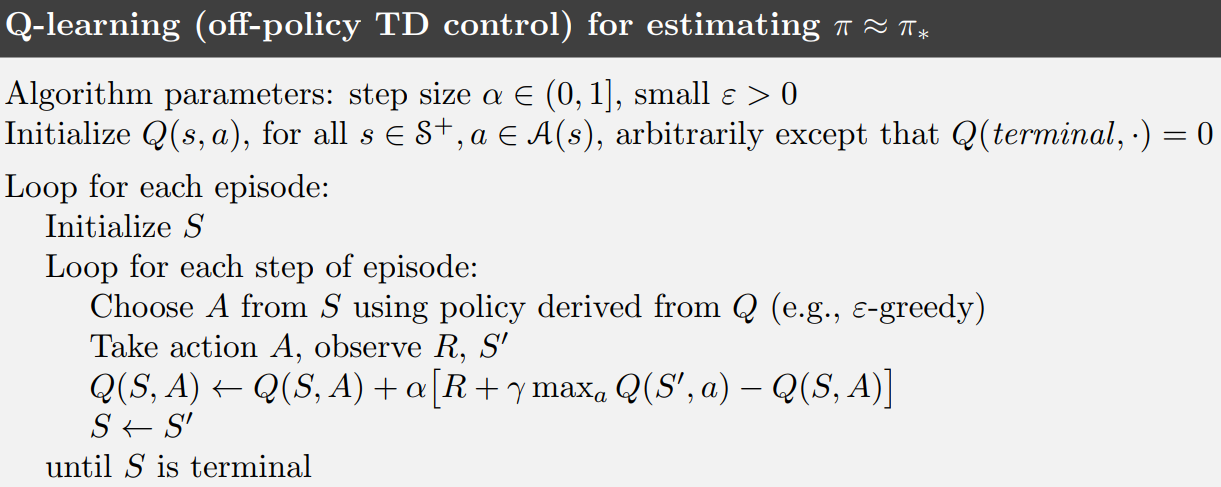

# Python Implementation

In [ ]:
import random
import numpy as np
from gym import Env

In [ ]:
class BoardEnv(Env):

    def __init__(self):

        self.size = (10, 10)  # (x_position, y_position) - size of the board - tuple - fixed
        self.item_pickup_pos = (0, 0)  # (x_position, y_position) - tuple - fixed
        self.item_drop_off_pos = (9, 9)  # (x_position, y_position) - tuple - fixed

        self.carrier_pos = (9, 0)  # (x_position, y_position) - tuple - not fixed
        self.is_item_in_carrier = False  # [False, True] - not fixed

        self.action_space = [0, 1, 2, 3, 4, 5]  # go up / go down / go left / go right / pick up / drop off

        self.state_space = []
        for x_pos_carrier in range(self.size[0]):
            for y_pos_carrier in range(self.size[1]):
                for item_in_carrier in range(2):
                    self.state_space.append((x_pos_carrier, y_pos_carrier, item_in_carrier))

    def step(self, action):

        if action == 0:  # Go down
            if self.carrier_pos[1] == self.size[1] - 1:
                reward = -10
                done = False
            else:
                self.carrier_pos = (self.carrier_pos[0], self.carrier_pos[1] + 1)  # Update position
                reward = -1
                done = False

        elif action == 1:  # Go up
            if self.carrier_pos[1] == 0:
                reward = -10
                done = False
            else:
                self.carrier_pos = (self.carrier_pos[0], self.carrier_pos[1] - 1)  # Update position
                reward = -1
                done = False

        elif action == 2:  # Go left
            if self.carrier_pos[0] == 0:
                reward = -10
                done = False
            else:
                self.carrier_pos = (self.carrier_pos[0] - 1, self.carrier_pos[1])  # Update position
                reward = -1
                done = False

        elif action == 3:  # Go right
            if self.carrier_pos[0] == self.size[0] - 1:
                reward = -10
                done = False
            else:
                self.carrier_pos = (self.carrier_pos[0] + 1, self.carrier_pos[1])  # Update position
                reward = -1
                done = False

        elif action == 4:  # Pick up item
            if not self.is_item_in_carrier and self.carrier_pos == self.item_pickup_pos:
                self.is_item_in_carrier = True
                reward = 20
                done = False
            else:
                reward = -10
                done = False

        elif action == 5:  # Drop off item
            if self.is_item_in_carrier and self.carrier_pos == self.item_drop_off_pos:
                self.is_item_in_carrier = False
                reward = 20
                done = True
            else:
                reward = -10
                done = False

        state = (self.carrier_pos[0], self.carrier_pos[1], int(self.is_item_in_carrier))

        info = {}

        return state, reward, done, info

    def render(self):
        pass

    def reset(self):
        """
        Resets the environment for a new episode.
        """

        self.carrier_pos = (9, 0)
        self.is_item_in_carrier = False
        state = (self.carrier_pos[0], self.carrier_pos[1], int(self.is_item_in_carrier))
        return state

In [ ]:
class Agent:

    def __init__(self, alpha, epsilon, gamma, state_space, action_space):

        # Step I of the Q-learning algorithm
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.state_space = state_space
        self.action_space = action_space
        self.length_of_action_space = len(self.action_space)

        # Step II of the Q-learning algorithm
        self.Q = {}
        for state in self.state_space:
            self.Q[state] = [0 for _ in range(self.length_of_action_space)]

    def policy(self, state):

        if random.uniform(0, 1) < self.epsilon:
            action = self.action_space[random.randint(0, self.length_of_action_space - 1)]
        else:
            action = np.argmax(self.Q[state])

        return action

    def update_policy(self, state, action, reward, state_):

        self.Q[state][action] = self.Q[state][action] + self.alpha * (reward + self.gamma * np.max(self.Q[state_]) - self.Q[state][action])

In [ ]:
env = BoardEnv()

state_space = env.state_space
action_space = env.action_space

alpha = 0.1
epsilon = 0.1
gamma = 0.6

agent = Agent(alpha, epsilon, gamma, state_space, action_space)

episodes = 30000

for episode in range(1, episodes + 1):

    observation = env.reset()
    done = False
    total_reward = 0
    steps = 0

    actions = []

    while not done:

        # env.render()
        action = agent.policy(observation)
        observation_, reward, done, info = env.step(action)
        agent.update_policy(observation, action, reward, observation_)
        observation = observation_
        total_reward += reward
        steps += 1

        actions.append(action)

    print(f"============ Episode: {episode} ============")
    print(f"Total Reward: {total_reward}")
    print(f"Steps: {steps}")
    print(f"Actions: {actions}")

# env.close()